# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 


In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 

from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.visualize   import plot_gaussian
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 5                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 5                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
config.display() 

# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

try :
    del model, train_generator, val_generator, mm
    gc.collect()
except: 
    pass
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow Version: 1.6.0   Keras Version : 2.1.3 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)


# Create Model

In [26]:
try :
    del model
    gc.collect()
except: 
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120) 

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)

model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
KB.set_learning_phase(1)

>>> Set_log_dir() -- model dir is  E:\Models\mrcnn_logs
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180422T1823\mask_rcnn_shapes_{epoch:04d}.h5

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
 @@@@@@ Input_shape  :  (None, 134, 134, 3)         Input_dim  :  3
        Kernel shape :  (7, 7, 3, 64)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)
 @@@@@@ Input_shape  :  (None, 32, 32, 64)         Input_dim  :  64
        Kernel shape :  (1, 1, 64, 64)
 @@@@@@ Input_shape  :  (None, 32, 32, 64)         Input_dim  :  64
        Kernel shape :  (3, 3, 64, 64)
 @@@@@@ Input_shape  :  (None, 32, 32, 64)         Input_dim  :  64
        Kernel shape :  (1, 1, 64, 256)
 @@@@@@ Input_shape  :  (None, 32, 32, 64)         Input_dim  :  64
        Kernel shape :  (1, 1,

     Scores :  (5, 4092)
     Deltas :  (5, 4092, 4)
     Anchors:  (5, 4092, 4)
     Boxes shape / type after processing:  (5, 4092, 4) <class 'tensorflow.python.framework.ops.Tensor'>

>>> Detection Target Layer 
>>> Detection Target Layer : call  <class 'list'> 4
     proposals.shape    : (5, ?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_class_ids.shape : (?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_bboxes.shape    : (?, ?, 4) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_masks.shape     : (?, 56, 56, ?) <class 'tensorflow.python.framework.ops.Tensor'>
>>> Detection Target Layer : return call  <class 'list'> 4
     output 0  shape (5, ?, ?)  type <class 'tensorflow.python.framework.ops.Tensor'> 
     output 1  shape (5, ?)  type <class 'tensorflow.python.framework.ops.Tensor'> 
     output 2  shape (5, ?, ?)  type <class 'tensorflow.python.framework.ops.Tensor'> 
     output 3  shape (5, ?, ?, ?)  type <class 'tensorflow.python.framewor

     new_shape (2):  (2,) [16 16]
     new_shape (3):  (2,) [128 128]
     X after image.resize_bilinear:  (5, ?, ?, 4)
     Dimensions of X after set_shape() :  (5, 128, 128, 4)
    BilinearUpSampling2D. compute_output_shape()
   FCN output (fcn_bilinear) shape is :  (5, 128, 128, 4)
>>> rpn_bbox_loss_graph
    rpn_match size : (?, ?)
    rpn_bbox  size : (?, ?, 4)
    tf default session:  <tensorflow.python.client.session.InteractiveSession object at 0x00000144961223C8>
>>> rpn_bbox_loss_graph
    rpn_match size : (?, ?)
    rpn_bbox  size : (?, ?, 4)
    tf default session:  <tensorflow.python.client.session.InteractiveSession object at 0x00000144961223C8>
>>> mrcnn_class_loss_graph 
    target_class_ids  size : (5, ?)
    pred_class_logits size : (?, 32, 4)
    active_class_ids  size : (?, ?)
>>> mrcnn_class_loss_graph 
    target_class_ids  size : (?, 1)
    pred_class_logits size : (?, 32, 4)
    active_class_ids  size : (?, ?)
>>> mrcnn_bbox_loss_graph 
    target_class_ids  siz

###  Print some model information 

In [ ]:
# print('\n Learning phase values is L ' ,KB.learning_phase())
# print('\n Metrics (_get_deduped_metrics_names():) ') 
# pp.pprint(model.keras_model._get_deduped_metrics_names())
# print('\n Outputs: ') 
# pp.pprint(model.keras_model.outputs)
# print('\n Losses (model.metrics_names): ') 
# pp.pprint(model.keras_model.metrics_names)

model.keras_model.summary(line_length = 150) 

### Define Data Generator

In [12]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

### Get next shapes from generator and display loaded shapes

In [13]:
train_batch_x, train_batch_y = next(train_generator)


>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
      Anchor  stride:   1
      Feature shapes:   [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
      Feature strides:  [4, 8, 16, 32, 64]
    Size of anchor array is : (4092, 4)


### Display loaded shapes

Image id:  95
Image meta [ 95 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3]


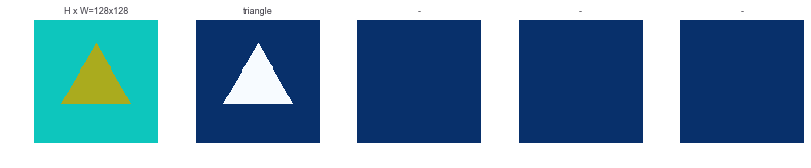

Image id:  433
Image meta [433 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1]


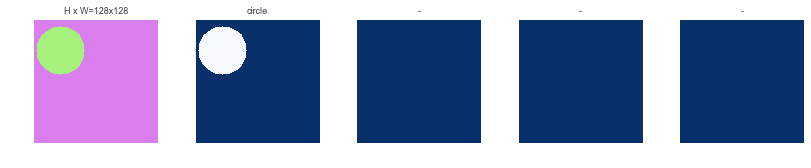

Image id:  326
Image meta [326 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 3 1]


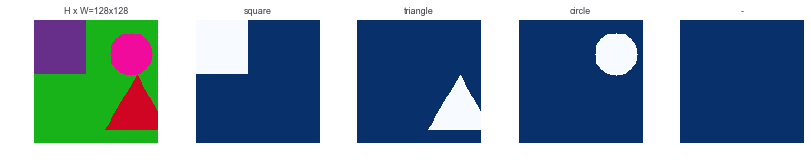

Image id:  472
Image meta [472 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 2 1 1]


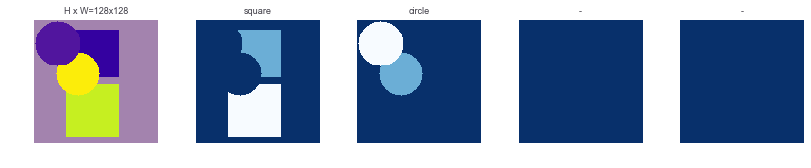

Image id:  338
Image meta [338 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 3 3]


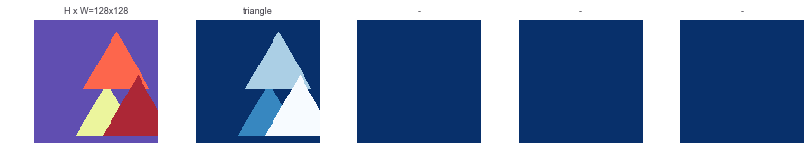

In [27]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)



### Push Data thru model using get_layer_output()

In [29]:

layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)


/* Inputs */
Input 0:  (input_image             ) 	  Input shape: (5, 128, 128, 3)
Input 1:  (input_image_meta        ) 	  Input shape: (5, 12)
Input 2:  (input_rpn_match         ) 	  Input shape: (5, 4092, 1)
Input 3:  (input_rpn_bbox          ) 	  Input shape: (5, 256, 4)
Input 4:  (input_gt_class_ids      ) 	  Input shape: (5, 100)
Input 5:  (input_gt_boxes          ) 	  Input shape: (5, 100, 4)
Input 6:  (input_gt_masks          ) 	  Input shape: (5, 56, 56, 100)
   input_tensor shape is  (5, 4, 32, 8)
   num of bboxes per class is :  32
   gauss_sum shape            :  (5, 4, 128, 128)
   input_tensor shape is  (5, 4, 100, 8)
   num of bboxes per class is :  100
   gauss_sum shape            :  (5, 4, 128, 128)

/* Outputs */
Output 0: (output_rois             ) 	  Output shape: (5, 32, 4)
Output 1: (proposal_targets        ) 	  Output shape: (5, 32)
Output 2: (proposal_targets        ) 	  Output shape: (5, 32, 4)
Output 3: (proposal_targets        ) 	  Output shape: (5, 32, 28, 2

### Display first two images from training batch 

Image id:  326


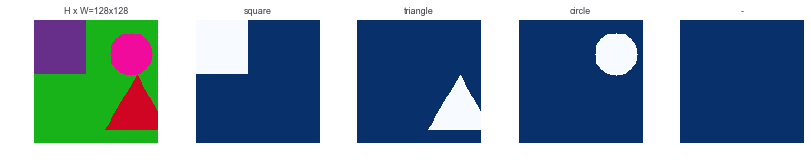

Image id:  472


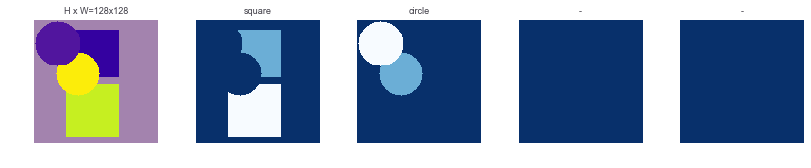

In [30]:
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]
img         = 2
image_id = img_meta[img,0]
print('Image id: ',image_id)

image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

img = 3
image_id = img_meta[img,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)
`gt_gaussian` and `gt_gaussian2` from Numpy and Tensorflow PCN layers

gt_gaussian heatmap shape :  (5, 128, 128, 4)  pred_gaussian heatmap shape:  (5, 128, 128, 4)
Image id:  326
Classes (1: circle, 2: square, 3: triangle ): 


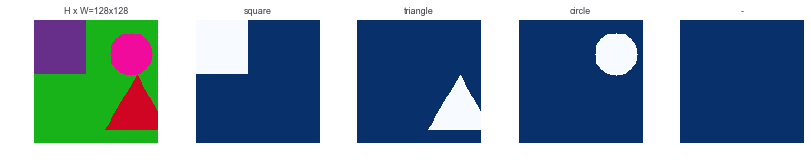

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 0 


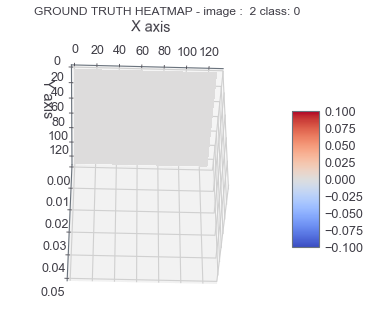

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 0 


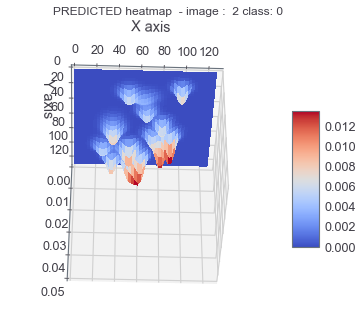

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 1 


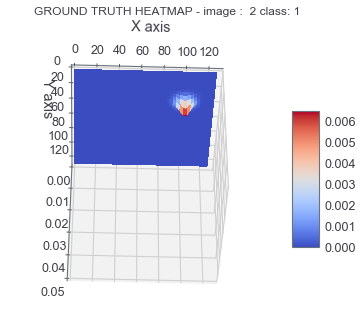

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 1 


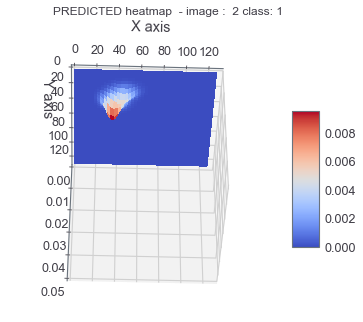

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 2 


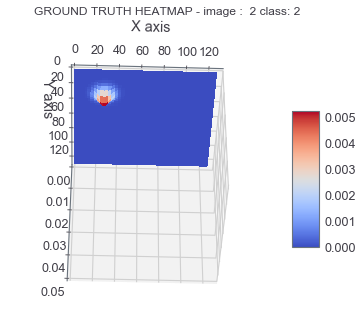

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 2 


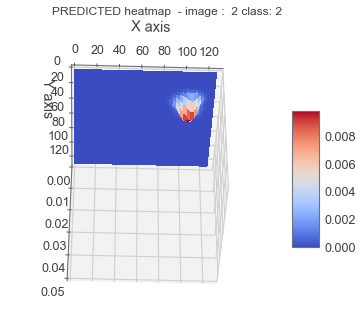

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 3 


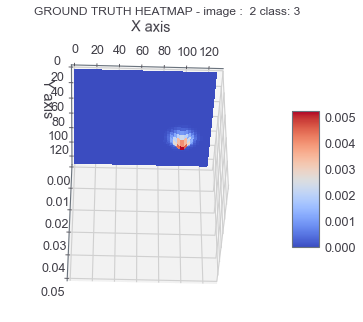

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 3 


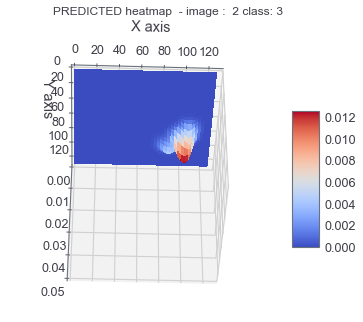

In [31]:
gt_heatmap  = layers_out[27]     # gt_gaussiam 
pred_heatmap= layers_out[24]  # pred_gaussian

print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 2

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  



## Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian`  (NUMPY)
`gt_gaussian` and `gt_gaussian2` from Numpy and Tensorflow PCN layers

gt_gaussian heatmap shape :  (5, 128, 128, 4)  pred_gaussian heatmap shape:  (5, 128, 128, 4)
Image id:  326
Classes (1: circle, 2: square, 3: triangle ): 


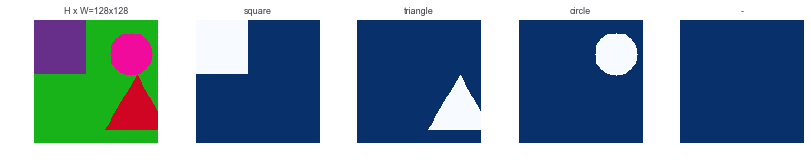

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 0 


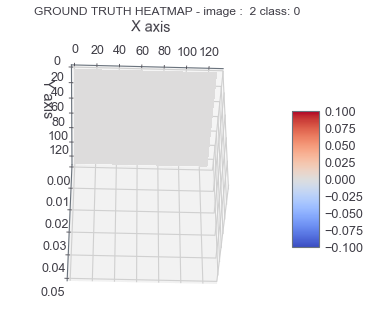

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 0 


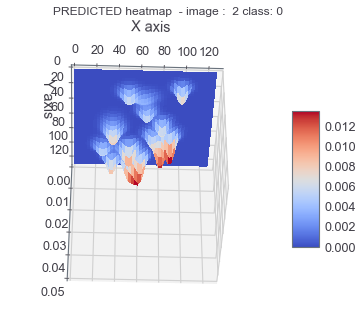

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 1 


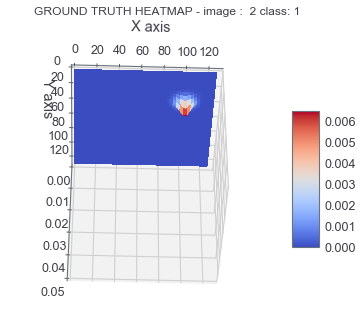

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 1 


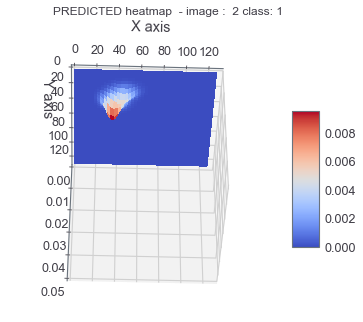

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 2 


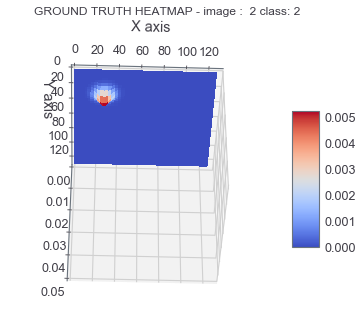

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 2 


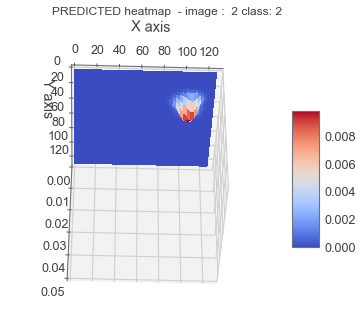

 *** Zout   (128, 128) GROUND TRUTH HEATMAP - image :  2 class: 3 


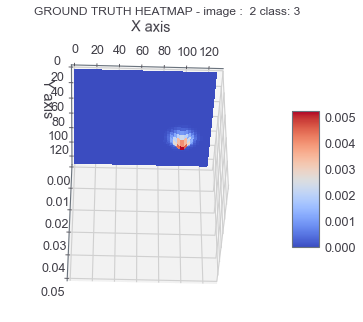

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 3 


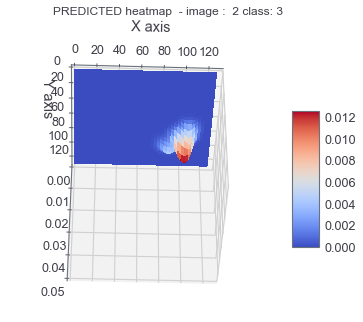

In [32]:
gt_heatmap  = layers_out[21]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian

print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 2

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  


## Plot Predicition Probability Heatmaps `pred_gaussian` and `pred_gaussian2` (Numpy vs. Tensorflow)

`pred_gaussian` and `pred_gaussian2` from Numpy and Tensorflow layers 

pred_gaussian_np heatmap shape :  (5, 128, 128, 4)  pred_gaussian_tf heatmap shape:  (5, 128, 128, 4)
Image id:  326
Classes (1: circle, 2: square, 3: triangle ): 


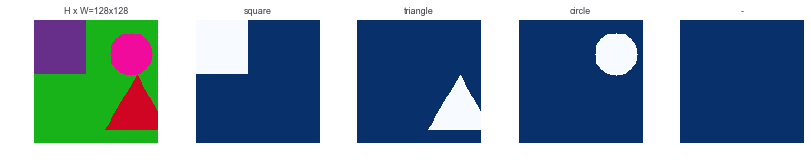

 *** Zout   (128, 128) NUMPY predicted HEATMAP - image :  2 class: 0 


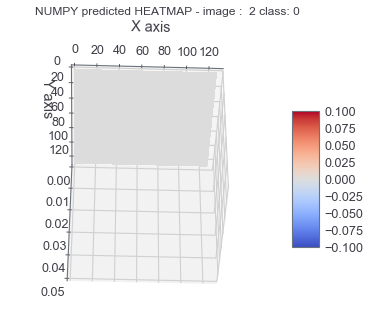

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 0 


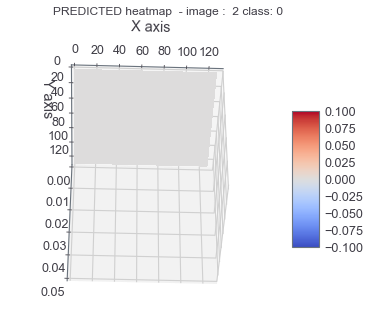

 *** Zout   (128, 128) NUMPY predicted HEATMAP - image :  2 class: 1 


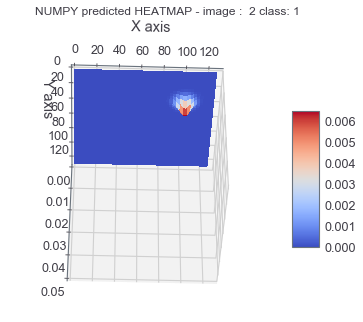

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 1 


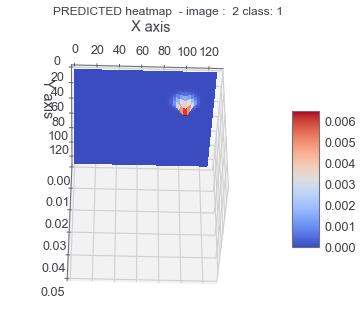

 *** Zout   (128, 128) NUMPY predicted HEATMAP - image :  2 class: 2 


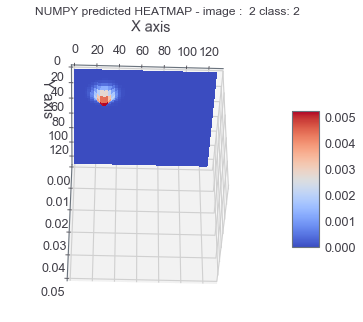

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 2 


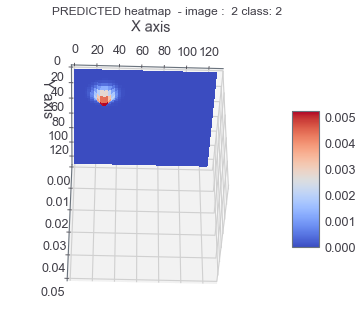

 *** Zout   (128, 128) NUMPY predicted HEATMAP - image :  2 class: 3 


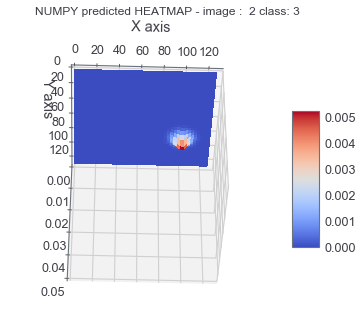

 *** pred_heatmap  (128, 128) PREDICTED heatmap  - image :  2 class: 3 


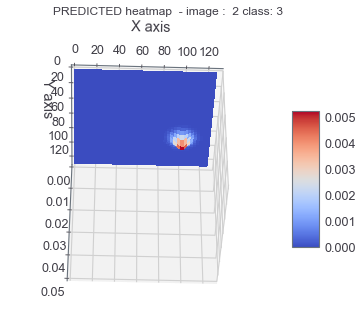

In [34]:
# pred_heatmap_np = layers_out[18]  # pred_gaussiam 
# pred_heatmap_tf = layers_out[24]  # pred_gaussian2
pred_heatmap_np = layers_out[21]  # pred_gaussiam 
pred_heatmap_tf = layers_out[27]  # pred_gaussian2

print('pred_gaussian_np heatmap shape : ', pred_heatmap_np.shape, ' pred_gaussian_tf heatmap shape: ', pred_heatmap_tf.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 2

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(num_classes):
    ttl = 'NUMPY predicted HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', pred_heatmap_np[img,:,:,cls].shape, ttl)   
    plot_gaussian( pred_heatmap_np[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap_tf[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap_tf[img,:,:,cls], title = ttl)  
  


## Plot Output from FCN network `fcn_bilinear` and compare with `pred_gaussian`


In [ ]:
from mrcnn.visualize import plot_gaussian
Zout  = layers_out[7]     # gt_gaussiam 
Zout2 = layers_out[18]    # gt_gaussian2

print(Zout.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0
for cls in range(num_classes):
    ttl = 'NUMPY - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', Zout[img,:,:,cls].shape, ttl)   
    plot_gaussian( Zout[img,:,:,cls], title = ttl)
    
    ttl = 'TENSORFLOW - image :  {} class: {} '.format(img,cls)     
    print(' *** Zout2 ', Zout2[img,:,:,cls].shape, ttl)   
    plot_gaussian(Zout2[img,:,:,cls], title = ttl)  


### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

Image id:  326
[[  0   0  57  54]
 [ 58  73 115 128]
 [ 14  78  59 123]]
[2 3 1]
Image id:  326
[[  0   0  57  54]
 [ 58  73 115 128]
 [ 14  78  59 123]]
[2 3 1]


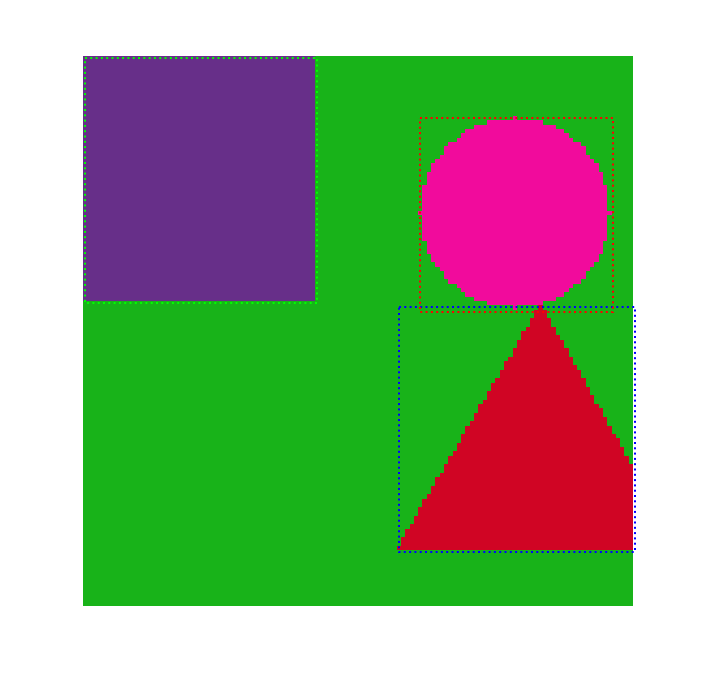

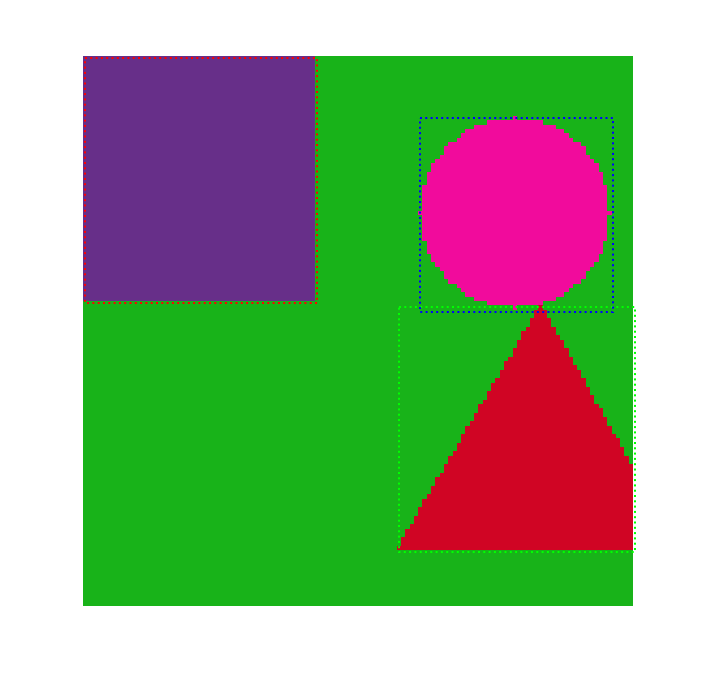

In [36]:
img = 2
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox)

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

Image id:  326
 input shape is :  (4, 100, 8)
 output shape is :  (3, 8)
[[  0.   1.  14.  78.  59. 123.   1.   2.]
 [  0.   1.   0.   0.  57.  54.   2.   0.]
 [  0.   1.  58.  73. 115. 128.   3.   1.]]
Image id:  326
 input shape is :  (4, 100, 8)
 output shape is :  (3, 8)
 From pcn_layer_tf (TENSORFLOW)
[[  2.   1.  14.  78.  59. 123.   1.   0.]
 [  0.   1.   0.   0.  57.  54.   2.   0.]
 [  1.   1.  58.  73. 115. 128.   3.   0.]]


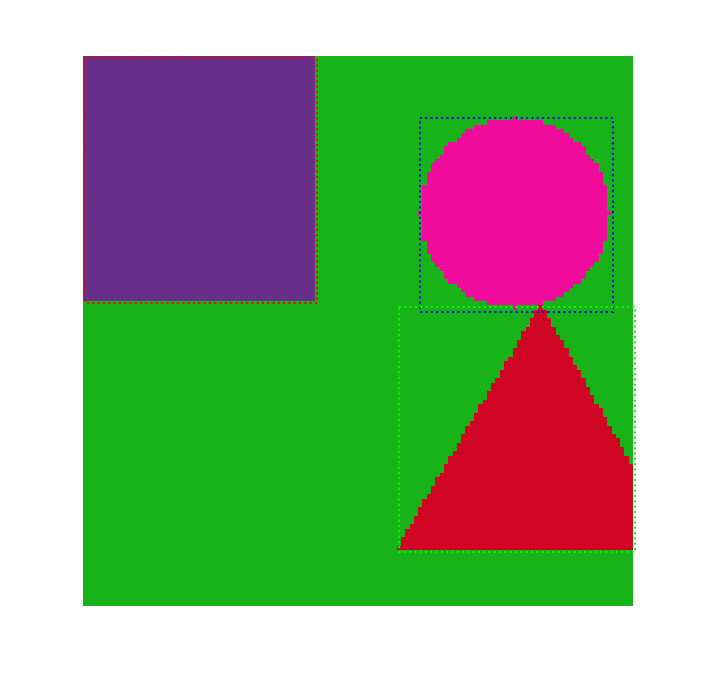

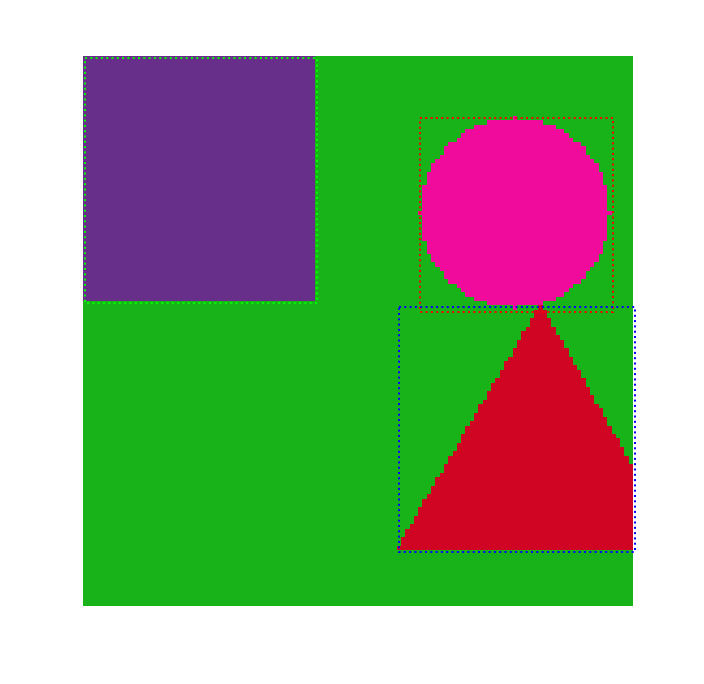

In [38]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 2
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[22][img])
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,2:6])


print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[28][img])
print(' From pcn_layer_tf (TENSORFLOW)')
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,2:6])

### Display Predicted Bounding Boxes  `pred_tensor` and `pred_tensor2` 

layers_out[19]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes - Using Numpy
layers_out[25]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes - Using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

Image id:  326
 input shape is :  (4, 32, 8)
 output shape is :  (30, 8)
[[ 14.       1.      99.7683  32.4556 128.      69.531    0.       0.    ]
 [ 11.       1.      97.3243  15.4641 128.      54.2262   0.       1.    ]
 [ 17.       1.      98.9233  39.4147 128.      79.1114   0.       2.    ]
 [ 13.       0.9999   0.      76.9983  35.6981 116.5164   0.       3.    ]
 [ 20.       0.9999  88.5813  43.1517 128.      82.095    0.       4.    ]
 [ 27.       0.9995  57.0541  49.2387 102.3642  95.4881   0.       7.    ]
 [ 18.       0.9994  23.9368  40.9669  72.9367  91.7936   0.       8.    ]
 [ 10.       0.998   70.8903  62.8076 104.1154  94.9756   0.       9.    ]
 [ 12.       0.9974  63.3233  68.3725  96.9233 107.7846   0.      10.    ]
 [ 19.       0.9954  71.7117  60.4293 115.1306 103.4886   0.      11.    ]
 [ 16.       0.9915  46.658    9.2668 102.0223  63.6962   0.      12.    ]
 [ 25.       0.9915  42.6467  59.8403  85.0829 101.5231   0.      13.    ]
 [ 21.       0.9893  75.979

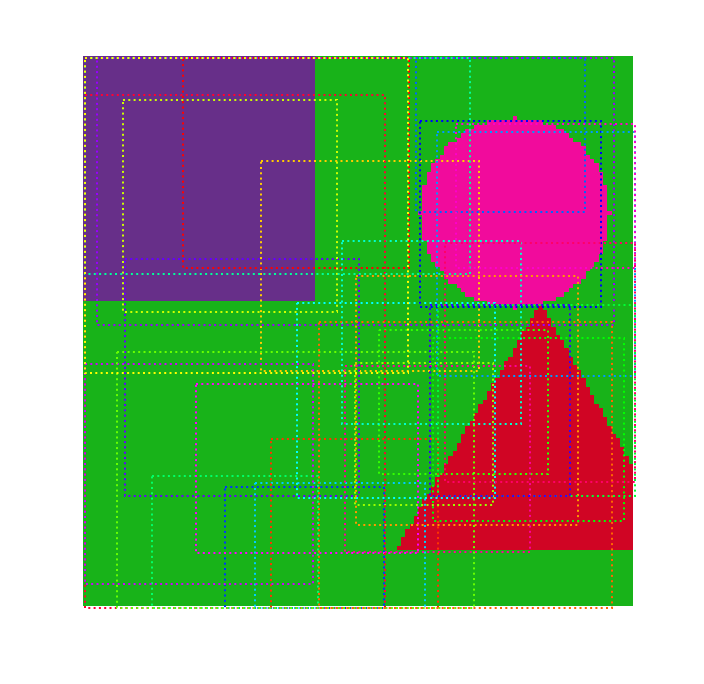

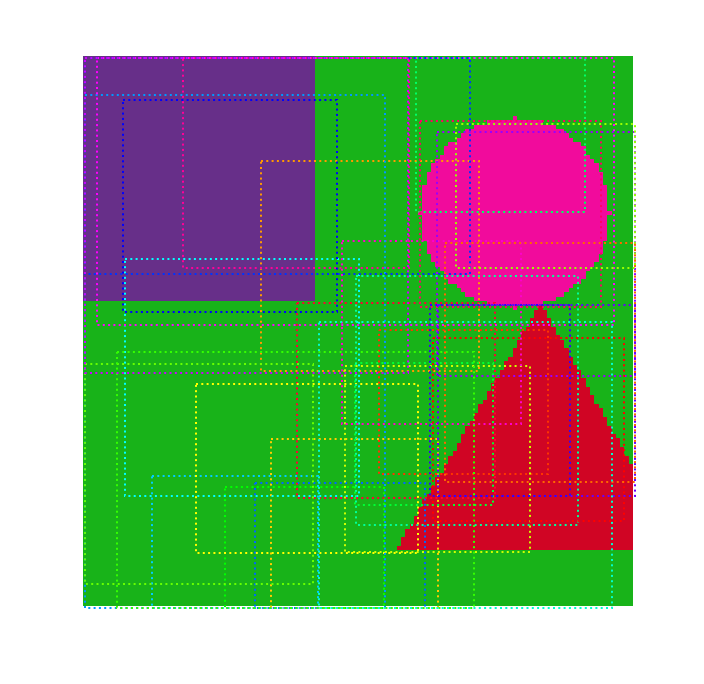

In [39]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 2
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[19][img])
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,2:6])


print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[25][img])
print(' From pcn_layer_tf (TENSORFLOW)')
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[:,2:6])

In [ ]:
np.set_printoptions(linewidth=120, precision=5)
print(' gt_cls_cnt from Numpy - shape: ', layers_out[5].shape)
print(layers_out[5])


print(' gt_cls_cnt from TF - shape: ', layers_out[13].shape)
print(layers_out[13])


## Display RoI proposals `pred_bboxes` generated for one class

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle 3

In [ ]:
img = 0
cls = 3 # <==== Class to display

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)

pred_tensor = layers_out[4]
print(pred_tensor[img,cls,:].shape)
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
print(caps)

visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

## Display RoI proposals `pred_bboxes` generated for all classes in image

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle -3

In [ ]:
img = 0
# cls = 1  # <==== Class to dispaly

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)

pred_tensor = layers_out[4][img]
print(pred_tensor[img,cls,:].shape)
pred_bboxes_stacked = stack_tensors_3d(pred_tensor)
# lst2   = [np.squeeze(item) for item in np.split(pred_tensor, pred_tensor.shape[0], axis = 0 )]
# results = np.concatenate( [ i[~np.all(i[:,2:6] == 0, axis=1)] for i in lst2] , axis = 0)
caps = [str(int(x[6]))+'-'+str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_bboxes_stacked.tolist() ]
print(caps)

# print(pc_tensor.pred_tensor[1,3,:])
# print(pc_tensor.pred_tensor[1,3,:,2:6])
visualize.draw_boxes(p_image, pred_bboxes_stacked[:,2:6], captions = caps)




#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
# caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
# print(caps)

# visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

For each class:
- determine the center of each bounding box.
- center a 2d gaussian distribution with the mean = center of bounding box and sigma = height/width
- place dist on mesh grid
- normalize
- draw heatmap

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

### Create Model

In [ ]:

# del history
try :
    del model
    gc.collect()
except: 
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120)
# print(model.find_last())

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

## Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run =2, 
            layers='heads')

## - Training heads using train_in_batches ()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...


In [ ]:
model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 2,
            layers='heads')

## Simulate one training iteration - 1

In [ ]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
learning_rate=model.config.LEARNING_RATE
epochs_to_run = 2
layers='heads'
batch_size = 0
steps_per_epoch = 0
# assert self.mode == "training", "Create model in training mode."
# Pre-defined layer regular expressions
layer_regex = {
    # all layers but the backbone
    "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # From a specific Resnet stage and up
    "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # All layers
    "all": ".*",
}

if layers in layer_regex.keys():
    layers = layer_regex[layers]
if batch_size == 0 :
    batch_size = model.config.BATCH_SIZE            
if steps_per_epoch == 0:
    steps_per_epoch = model.config.STEPS_PER_EPOCH

# Data generators
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=batch_size)
val_generator   = data_generator(dataset_val, model.config, shuffle=True,
                                 batch_size=batch_size,
                                 augment=False)

# Train
log("Last epoch completed : {} ".format(model.epoch))
log("Starting from epoch {} for {} epochs. LR={}".format(model.epoch, epochs_to_run, learning_rate))
log("Steps per epoch:    {} ".format(steps_per_epoch))
log("Batchsize      :    {} ".format(batch_size))
log("Checkpoint Folder:  {} ".format(model.checkpoint_path))
epochs = model.epoch + epochs_to_run

from tensorflow.python.platform import gfile
if not gfile.IsDirectory(model.log_dir):
    log('Creating checkpoint folder')
    gfile.MakeDirs(model.log_dir)
else:
    log('Checkpoint folder already exists')

model.set_trainable(layers)            
model.compile(learning_rate, model.config.LEARNING_MOMENTUM)        

out_labels = model.keras_model._get_deduped_metrics_names()
callback_metrics = out_labels + ['val_' + n for n in out_labels]

progbar = keras.callbacks.ProgbarLogger(count_mode='steps')
progbar.set_model(model.keras_model)
progbar.set_params({
    'epochs': epochs,
    'steps': steps_per_epoch,
    'verbose': 1,
    'do_validation': False,
    'metrics': callback_metrics,
})

progbar.set_model(model.keras_model) 

chkpoint = keras.callbacks.ModelCheckpoint(model.checkpoint_path, 
                                           monitor='loss', verbose=1, save_best_only = True, save_weights_only=True)
chkpoint.set_model(model.keras_model)

progbar.on_train_begin()
epoch_idx = model.epoch

## Simulate one training iteration - 2

In [ ]:
if epoch_idx >= epochs:
    print('Final epoch {} has already completed - Training will not proceed'.format(epochs))

# while epoch_idx < epochs :
progbar.on_epoch_begin(epoch_idx)
steps_index = 0
# for steps_index in range(steps_per_epoch):

batch_logs = {}
print(' self.epoch {}   epochs {}  step {} '.format(model.epoch, epochs, steps_index))
batch_logs['batch'] = steps_index
batch_logs['size']  = batch_size
progbar.on_batch_begin(steps_index, batch_logs)

## Simulate one training iteration - 3

In [ ]:
imgmeta_idx= model.keras_model.input_names.index('input_image_meta')
img_meta  =  train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

outs = model.keras_model.train_on_batch(train_batch_x, train_batch_y)

# Stacking Routines
###  Stacking routine -- break down by images 

In [ ]:
## stack an [Batch x Class x Row x Col] tensor into Row x Cols
##------------------------------------------------------------------
pred_tensor = layers_out[8]
lst2 = [ np.squeeze(item) for item in np.split(pred_tensor, pred_tensor.shape[0], axis = 0 )]
lst2 = [ np.squeeze(np.concatenate(np
                                   .split(item, item.shape[0], axis = 0 ), axis = 1)) for item in lst2]
result = [ item[~np.all(item[:,2:6] == 0, axis=1)] for item in lst2]
print(len(result))
# print(result)

###  Stack tensor routine for one image 

In [ ]:
## stack an  [Class x Row x Col] tensor into Row x Cols
##------------------------------------------------------------------
pred_tensor = layers_out[8][0]
lst2   = [np.squeeze(item) for item in np.split(pred_tensor, pred_tensor.shape[0], axis = 0 )]
result = np.concatenate( [ i[~np.all(i[:,2:6] == 0, axis=1)] for i in lst2] , axis = 0)
print(result.shape)
# print(result)

# Verify matching results between numpy and tensorflow routines
### Control pred_tensor / pred_tensor2 on 100 training shapes

In [ ]:
for i in range(100):
    train_batch_x, train_batch_y = next(train_generator)

    layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1, verbose = False)

    pt   = layers_out[5]   # pred_tensor
    pt2  = layers_out[11]  # pred_tensor_2
    
#     pcc  = layers_out[9]   # pred_cls_cnt
#     pcc2 = layers_out[15]  # pred_cls_cnt_2

#     print( pt2.shape, pcc2.shape)
#     print( pt.shape, pt2.shape)
#     print(pc2)

    for img in range(config.BATCH_SIZE):
        for cls in range(4):
#             print(pt2[img][cls])
#             print(pt[img][cls])
            pt_equal = np.all(pt2[img,cls,:,1:-1]== pt[img,cls,:,1:-1], axis = -1)
            print('* Iteration', i , 'Image ',img,' Class ',cls, ' pred_tesnor == pred_tensor2 : ',pt_equal.all())
            
            if (~pt_equal.all()):
#                 print(' Iteration', i , 'Image ',img,' Class ',cls, ' ALL pt_equal: ',pt_equal.all())
                print(pt_equal)
                print('\n -- using numpy \n',pt[img][cls,~pt_equal,:-1])
                print('\n -- using tensorflow \n',pt2[img][cls,~pt_equal])
                print()
    #             print('\n -- using numpy \n',pt[img][cls])            
    #             print('\n -- using tensorflow \n',pt2[img][cls])
    

### Control pred_tesnor / pred_tensor2

In [ ]:
pt   = layers_out[4]   # pred_tensor
pt2  = layers_out[12] 
 
print( pt.shape, pt2.shape)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(pt[img][cls,:,1:7] == pt2[img][cls,:,1:7], axis = -1)
        print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print(' numpy results ')
#         print( pt[img,cls])
#         print('tensorflow results ')
#         print(pt2[img,cls])
        if (~equal.all()):
#             print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy (pt) \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow (pt2) \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

### Display pred_tensor from Numpy and Tensorflow PCN_Layer 

In [ ]:
# np.set_printoptions(threshold=99999, linewidth=2000)
# print(np.array2string(mask[...,0],max_line_width=2000,separator=''))
pt   = layers_out[4]   # pred_tensor
pt2  = layers_out[12] 
 
print( pt.shape, pt2.shape)
img = 0

for cls in range(4):
#     equal = np.all(pt[img][cls,:,1:7] == pt2[img][cls,:,1:7], axis = -1)
    print('Image ',img,' Class ',cls)
    print(' Output from PCN_Layer (Numpy)')
    print( pt[img,cls])
    print(' Output from PCN_Layer (Tensorflow)')
    print(pt2[img,cls])


###  pred_gaussian / pred_gaussian2  & gt_gaussian / gt_gaussian2

In [ ]:
# pt   = layers_out[4]   # pred_gaussian 
# pt2  = layers_out[10]  # pred_gaussian_2
np.set_printoptions(linewidth=130, threshold=20000)
gt   = layers_out[7]   # gt_gaussian 
gt2  = layers_out[13]  # gt_gaussian_2
# gt   = np.where(gt > 1e-6,gt,0)
# gt2   = np.where(gt2 > 1e-6,gt2,0)
print( ' pt shape ', gt.shape, ' pt2.shape ', gt2.shape)

for img in range(config.BATCH_SIZE):
#     print(' from np ')
#     print(pt[img])
#     print(' from tensorflow')
#     print(pt2[img])
    for cls in range(4):
        equal = np.all(gt2[img, cls] == gt[img, cls], axis=-1)      
        print( 'Image ',img,' Class ',cls, '  all equal: ',equal.all())        
        
        if (~equal.all()):
            print(~equal)
            print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#             print('\n -- using numpy      \n',  gt[img, cls, ~equal])
#             print('\n -- using tensorflow \n', gt2[img, cls, ~equal])
# if not equal display the different between the mismatching rows
            for i in range(equal.shape[0]):
                if ~equal[i]:
                    diff = np.abs(gt2[img, cls, i] - gt[img, cls, i])
                    big_error = np.any(diff > 3.0e-9, axis = -1)
                    print('   row = ', i, ' rows equal = ',equal[i], '   Big Error (larger than 7.0e-8): ' ,big_error)
                    if big_error:
                        print(' difference  :', diff )
#                     print(' -- using numpy      \n',gt[img,cls,i])            
#                     print(' -- using tensorflow \n',gt2[img,cls,i])
    